  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], Total Loss: 16237.0513, Reconst Loss: 14631.2240, KL Div: 1605.8272906, Val Loss: 12666.4281


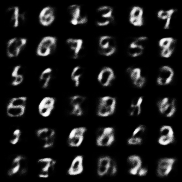

  4%|▍         | 1/25 [00:10<04:11, 10.48s/it]

Epoch[2/25], Total Loss: 11938.4571, Reconst Loss: 9604.9811, KL Div: 2333.4760576, Val Loss: 11450.2038


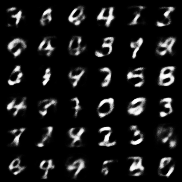

  8%|▊         | 2/25 [00:21<04:08, 10.80s/it]

Epoch[3/25], Total Loss: 11221.9788, Reconst Loss: 8707.3806, KL Div: 2514.5982144, Val Loss: 11041.6421


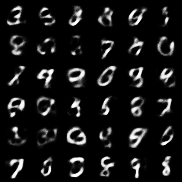

 12%|█▏        | 3/25 [00:32<03:59, 10.87s/it]

Epoch[4/25], Total Loss: 10926.2729, Reconst Loss: 8347.5584, KL Div: 2578.7144453, Val Loss: 10875.1750


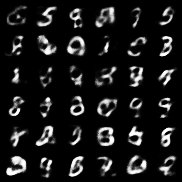

 16%|█▌        | 4/25 [00:46<04:06, 11.74s/it]

Epoch[5/25], Total Loss: 10740.4791, Reconst Loss: 8132.3353, KL Div: 2608.1438438, Val Loss: 10732.3118


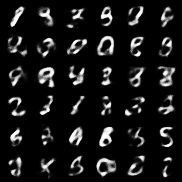

 20%|██        | 5/25 [00:59<03:58, 11.92s/it]

Epoch[6/25], Total Loss: 10611.0670, Reconst Loss: 7979.9912, KL Div: 2631.0757471, Val Loss: 10643.6912


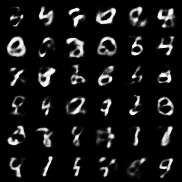

 24%|██▍       | 6/25 [01:11<03:47, 11.96s/it]

Epoch[7/25], Total Loss: 10515.1179, Reconst Loss: 7867.2645, KL Div: 2647.8533838, Val Loss: 10562.4845


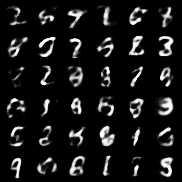

 28%|██▊       | 7/25 [01:24<03:37, 12.09s/it]

Epoch[8/25], Total Loss: 10441.4886, Reconst Loss: 7778.1818, KL Div: 2663.3068018, Val Loss: 10499.6519


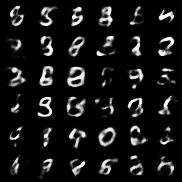

 32%|███▏      | 8/25 [01:36<03:25, 12.10s/it]

Epoch[9/25], Total Loss: 10381.3954, Reconst Loss: 7703.9253, KL Div: 2677.4700649, Val Loss: 10468.4603


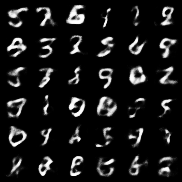

 36%|███▌      | 9/25 [01:48<03:13, 12.09s/it]

Epoch[10/25], Total Loss: 10319.9103, Reconst Loss: 7637.4128, KL Div: 2682.4974556, Val Loss: 10416.8236


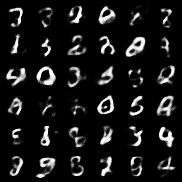

 40%|████      | 10/25 [02:00<03:01, 12.07s/it]

Epoch[11/25], Total Loss: 10279.0760, Reconst Loss: 7590.0546, KL Div: 2689.0213232, Val Loss: 10382.0953


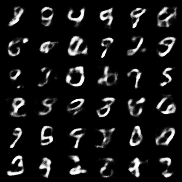

 44%|████▍     | 11/25 [02:12<02:49, 12.09s/it]

Epoch[12/25], Total Loss: 10246.3911, Reconst Loss: 7543.7245, KL Div: 2702.6665742, Val Loss: 10345.6334


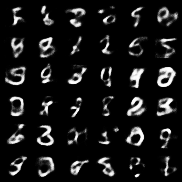

 48%|████▊     | 12/25 [02:25<02:37, 12.11s/it]

Epoch[13/25], Total Loss: 10212.8764, Reconst Loss: 7509.5117, KL Div: 2703.3647163, Val Loss: 10326.1215


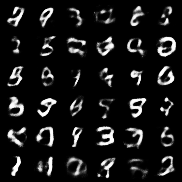

 52%|█████▏    | 13/25 [02:37<02:24, 12.08s/it]

Epoch[14/25], Total Loss: 10178.0622, Reconst Loss: 7464.9046, KL Div: 2713.1576152, Val Loss: 10311.6766


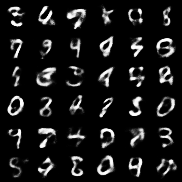

 56%|█████▌    | 14/25 [02:49<02:13, 12.10s/it]

Epoch[15/25], Total Loss: 10154.1720, Reconst Loss: 7437.5504, KL Div: 2716.6215981, Val Loss: 10276.4588


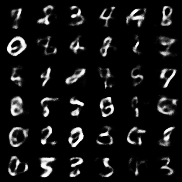

 60%|██████    | 15/25 [03:01<02:01, 12.12s/it]

Epoch[16/25], Total Loss: 10125.6286, Reconst Loss: 7407.1324, KL Div: 2718.4962251, Val Loss: 10266.6339


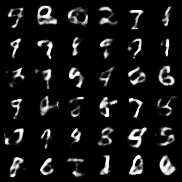

 64%|██████▍   | 16/25 [03:14<01:49, 12.13s/it]

Epoch[17/25], Total Loss: 10108.8869, Reconst Loss: 7381.9561, KL Div: 2726.9307632, Val Loss: 10260.0208


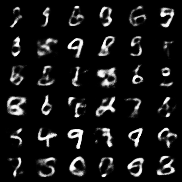

 68%|██████▊   | 17/25 [03:27<01:37, 12.18s/it]

Epoch[18/25], Total Loss: 10090.7966, Reconst Loss: 7362.7365, KL Div: 2728.0601362, Val Loss: 10252.2431


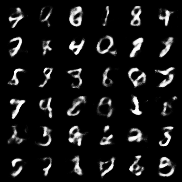

 72%|███████▏  | 18/25 [03:38<01:25, 12.17s/it]

Epoch[19/25], Total Loss: 10066.1177, Reconst Loss: 7335.9378, KL Div: 2730.1799175, Val Loss: 10245.7353


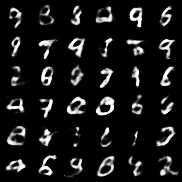

 76%|███████▌  | 19/25 [03:51<01:12, 12.17s/it]

Epoch[20/25], Total Loss: 10049.9233, Reconst Loss: 7316.2598, KL Div: 2733.6635366, Val Loss: 10225.1929


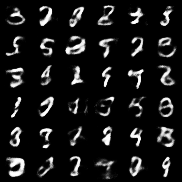

 80%|████████  | 20/25 [04:03<01:00, 12.18s/it]

Epoch[21/25], Total Loss: 10036.5079, Reconst Loss: 7298.5369, KL Div: 2737.9710205, Val Loss: 10203.5260


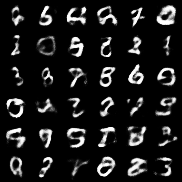

 84%|████████▍ | 21/25 [04:13<00:48, 12.05s/it]

Epoch[22/25], Total Loss: 10020.7753, Reconst Loss: 7278.4002, KL Div: 2742.3751187, Val Loss: 10218.2022


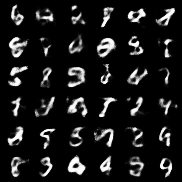

 88%|████████▊ | 22/25 [04:22<00:35, 11.93s/it]

Epoch[23/25], Total Loss: 10004.9678, Reconst Loss: 7262.9865, KL Div: 2741.9812642, Val Loss: 10205.8423


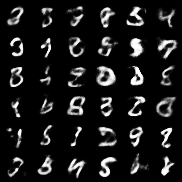

 92%|█████████▏| 23/25 [04:32<00:23, 11.84s/it]

Epoch[24/25], Total Loss: 9990.9488, Reconst Loss: 7246.1661, KL Div: 2744.7827388, Val Loss: 10187.0556


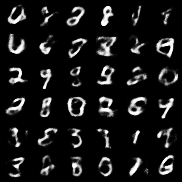

 96%|█████████▌| 24/25 [04:41<00:11, 11.74s/it]

Epoch[25/25], Total Loss: 9976.3325, Reconst Loss: 7231.9311, KL Div: 2744.4013950, Val Loss: 10174.4867


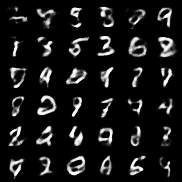

100%|██████████| 25/25 [04:51<00:00, 11.65s/it]


NameError: name 'ntrainer' is not defined

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.vae import *
    
# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = VAE(image_size=784,
            hidden_dim=400,
            z_dim=20)

# Init trainer
trainer = VAETrainer(model=model,
                     train_iter=train_iter,
                     val_iter=val_iter,
                     test_iter=test_iter,
                     viz=True)

# Train
trainer.train(num_epochs=25,
              lr=1e-3,
              weight_decay=1e-5)

# Plot loss
trainer.viz_loss()

# Explore latent space
trainer.make_all()

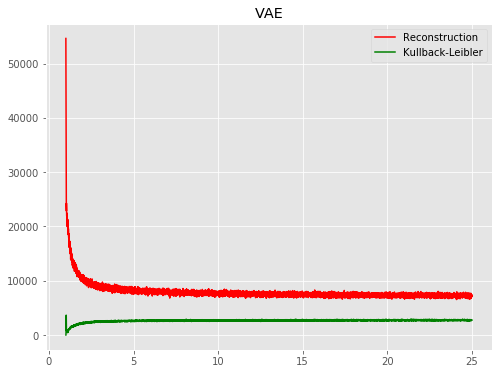

In [3]:
trainer.viz_loss()

Sampled images from latent space:


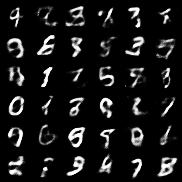

Interpolating between two randomly sampled


Exploring latent representations


 33%|███▎      | 1/3 [00:07<00:15,  7.92s/it]

Epoch[1/3], Total Loss: 19025.5532, Reconst Loss: 18489.1890, KL Div: 536.3642402, Val Loss: 17142.5896


 67%|██████▋   | 2/3 [00:15<00:07,  7.95s/it]

Epoch[2/3], Total Loss: 16897.6456, Reconst Loss: 16399.0053, KL Div: 498.6403270, Val Loss: 16528.0341


100%|██████████| 3/3 [00:27<00:00,  9.23s/it]

Epoch[3/3], Total Loss: 16508.2680, Reconst Loss: 15995.8657, KL Div: 512.4022518, Val Loss: 16256.5963


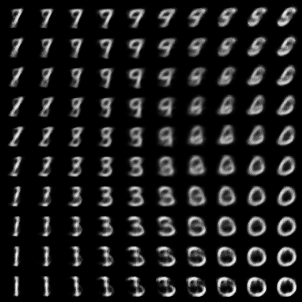

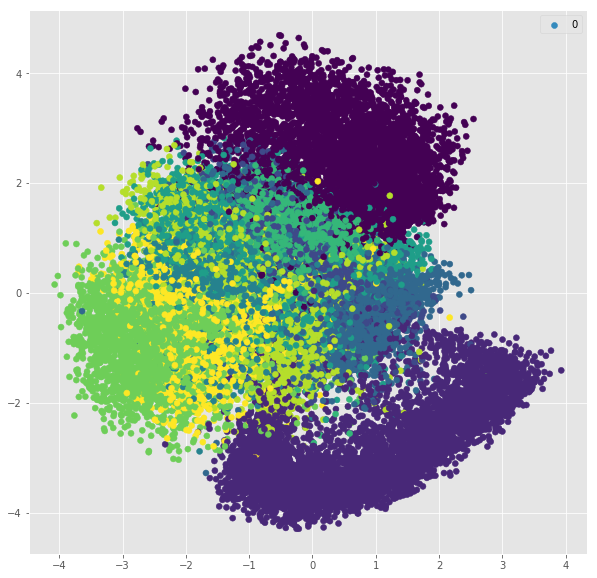

In [4]:
# Explore latent space
trainer.make_all()